# Costa Rican Household Poverty Level Prediction

또 다른 Kaggle 도전에 오신 것을 환영합니다! 코스타리카 가계 빈곤 수준 예측 대회의 목적은 개인의 특성과 가정의 특성을 모두 활용하여 가정의 빈곤 수준을 예측할 수 있는 머신러닝 모델을 개발하는 것입니다. 이 "선행을 위한 데이터 과학" 프로젝트는 사람들이 광고를 클릭하게 하는 것보다 사회에 더 유익한 일에 우리의 기술을 투입할 수 있는 기회를 제공합니다!

이 노트에서는 전체 머신러닝 솔루션에 대해 살펴보겠습니다. 먼저 문제를 소개하고, 데이터셋에 대한 철저한 탐색 데이터 분석을 수행하고, 기능 엔지니어링을 수행하고, 여러 머신러닝 모델을 사용해 보고, 모델을 선택하고, 모델을 최적화하고, 마지막으로 모델의 출력을 검사하고, 그리십시오. 

## Problem and Data Explanation

문제 및 데이터 설명입니다.
이 대회의 데이터는 train.csv와 test.csv의 두 가지 파일로 제공됩니다. 교육 세트에는 9557개의 행과 143개의 열이 있는 반면 검정 세트에는 23856개의 행과 142개의 열이 있습니다. 각 행은 한 개인을 나타내며, 각 열은 개인 또는 개인의 가정에 대한 특징입니다. 교육 세트에는 1-4 척도로 빈곤 수준을 나타내며 경쟁사의 레이블인 목표라는 추가 열이 있습니다. 1의 값은 극빈입니다.

이것은 감독되는 다중 클래스 분류 기계 학습 문제입니다.

감독: 교육 데이터의 레이블과 함께 제공됩니다.
다중 클래스 분류: 레이블은 4개의 클래스가 있는 이산형 값입니다.
객관적으로
목적은 빈곤을 가구 단위로 예측하는 것입니다. 우리는 개개인의 고유한 특징을 가진 개인 수준에 대한 데이터를 제공받지만 그들의 가계에 대한 정보도 제공합니다. 작업에 대한 데이터 세트를 만들려면 각 가구의 개별 데이터를 일부 집계해야 합니다. 게다가, 우리는 시험 세트에 있는 모든 개인에 대해 예측을 해야 하는데, "가장만 채점에 사용된다"는 것은 우리가 가구 단위로 빈곤을 예측하기를 원한다는 것을 의미합니다.

중요 사항: 교육 데이터에서 모든 가구원의 라벨은 동일해야 하지만, 동일한 가구원의 라벨이 서로 다른 오류가 있습니다. 이 경우 각 가구의 가장에 대한 레이블을 사용하도록 지시받았으며, 이 레이블은 parentesco1 == 1.0인 행으로 식별할 수 있습니다. 이 문제를 해결하는 방법은 노트에서 다루겠습니다(자세한 내용은 경쟁업체의 주요 논의를 참조하십시오).

- 1 = extreme poverty (극심한 빈곤)
- 2 = moderate poverty (적당한 빈곤)
- 3 = vulnerable households (취약계층)
- 4 = non vulnerable households (비취약 계층)



143개 열에 대한 설명은 경기 문서에서 확인할 수 있지만, 몇 가지 유의할 사항은 다음과 같습니다.

- ID : 각 개인에 대한 고유 식별자. 이 기능은 우리가 사용하는 기능이 아닙니다.
- idhogar : 각 가구의 고유 식별자입니다. 이 변수는 특징이 아니지만 한 가구의 모든 개인이 동일한 식별자를 갖게 되므로 가구별로 개인을 그룹화하는 데 사용됩니다.
- parentesco1 : 이 사람이 가장인지 여부를 나타냅니다.
- target : 한 가구의 모든 구성원에 대해 동일해야 하는 레이블입니다.

모델을 만들 때 각 가구당 가장의 빈곤수준을 표기한 라벨을 가지고 세대별로 교육할 것입니다. 원시 데이터에는 가구와 개인의 특성이 혼재되어 있는데 개별 데이터의 경우 가구별로 이를 집계할 수 있는 방법을 찾아야 할 것 같습니다. 개인들 중 일부는 가장이 없는 가정에 속해 있는데, 유감스럽게도 우리는 이 데이터를 훈련에 사용할 수 없습니다. 데이터와 관련된 이러한 문제는 실제 데이터에서 완전히 일반적인 문제이므로 데이터 과학 작업에서 발생할 데이터 세트를 준비하기에 적합합니다.

### Read in Data and Look at Summary Information


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


즉, 정수 열이 130개, 부동(숫자) 열이 8개, 객체 열이 5개 있습니다. 정수 열은 불변 변수(0 또는 1을 차지하는) 또는 이산형 순서 값을 갖는 순서형 변수를 나타냅니다. 객체 열은 기계 학습 모델에 직접 입력될 수 없기 때문에 문제가 될 수 있습니다.

열차보다 행(개체)이 더 많은 검정 데이터를 살펴보겠습니다. 대상이 없기 때문에 열이 하나 적습니다!

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


### Integer Columns

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.



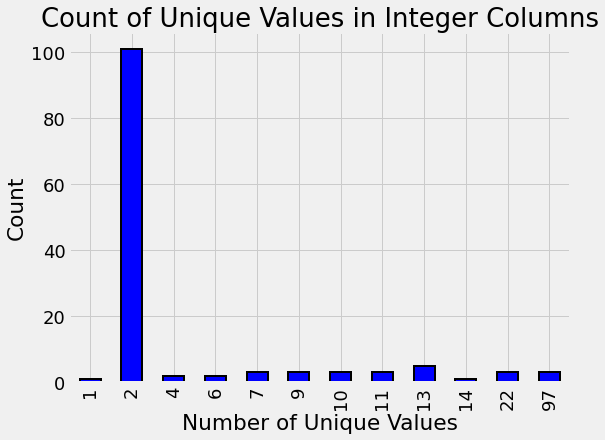

In [5]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

고유한 값이 2개만 있는 열은 부울란(0 또는 1)을 나타냅니다. 많은 경우, 이 불린 정보는 이미 가구 수준에 있습니다. 예를 들어, 냉장 칸에는 냉장고의 보유 여부가 표시됩니다. 가구 레벨에 있는 부울 컬럼에서 피쳐를 만들 시간이 되면 이를 집계할 필요가 없습니다. 그러나 개별 수준에 있는 부울 열을 집계해야 합니다.

### Float Columns

또 다른 열 유형은 연속형 변수를 나타내는 부동 소수입니다. 우리는 모든 부동 열의 분포를 보여주기 위해 빠른 분포도를 만들 수 있습니다. OrderedDict를 사용하여 부족 수준을 색상에 매핑합니다. 이렇게 하면 키와 값이 (일반 Python 사전과 달리) 지정한 순서에 따라 유지되기 때문입니다.

다음 그래프는 목표값으로 색상이 지정된 부동 열의 분포를 보여 줍니다. 이 그래프를 통해 가구의 빈곤 수준에 따라 변동 분포에 유의한 차이가 있는지 확인할 수 있습니다.

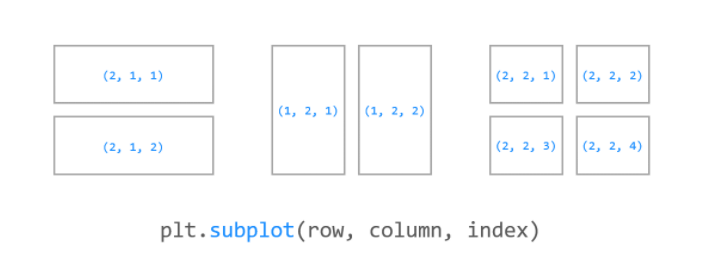

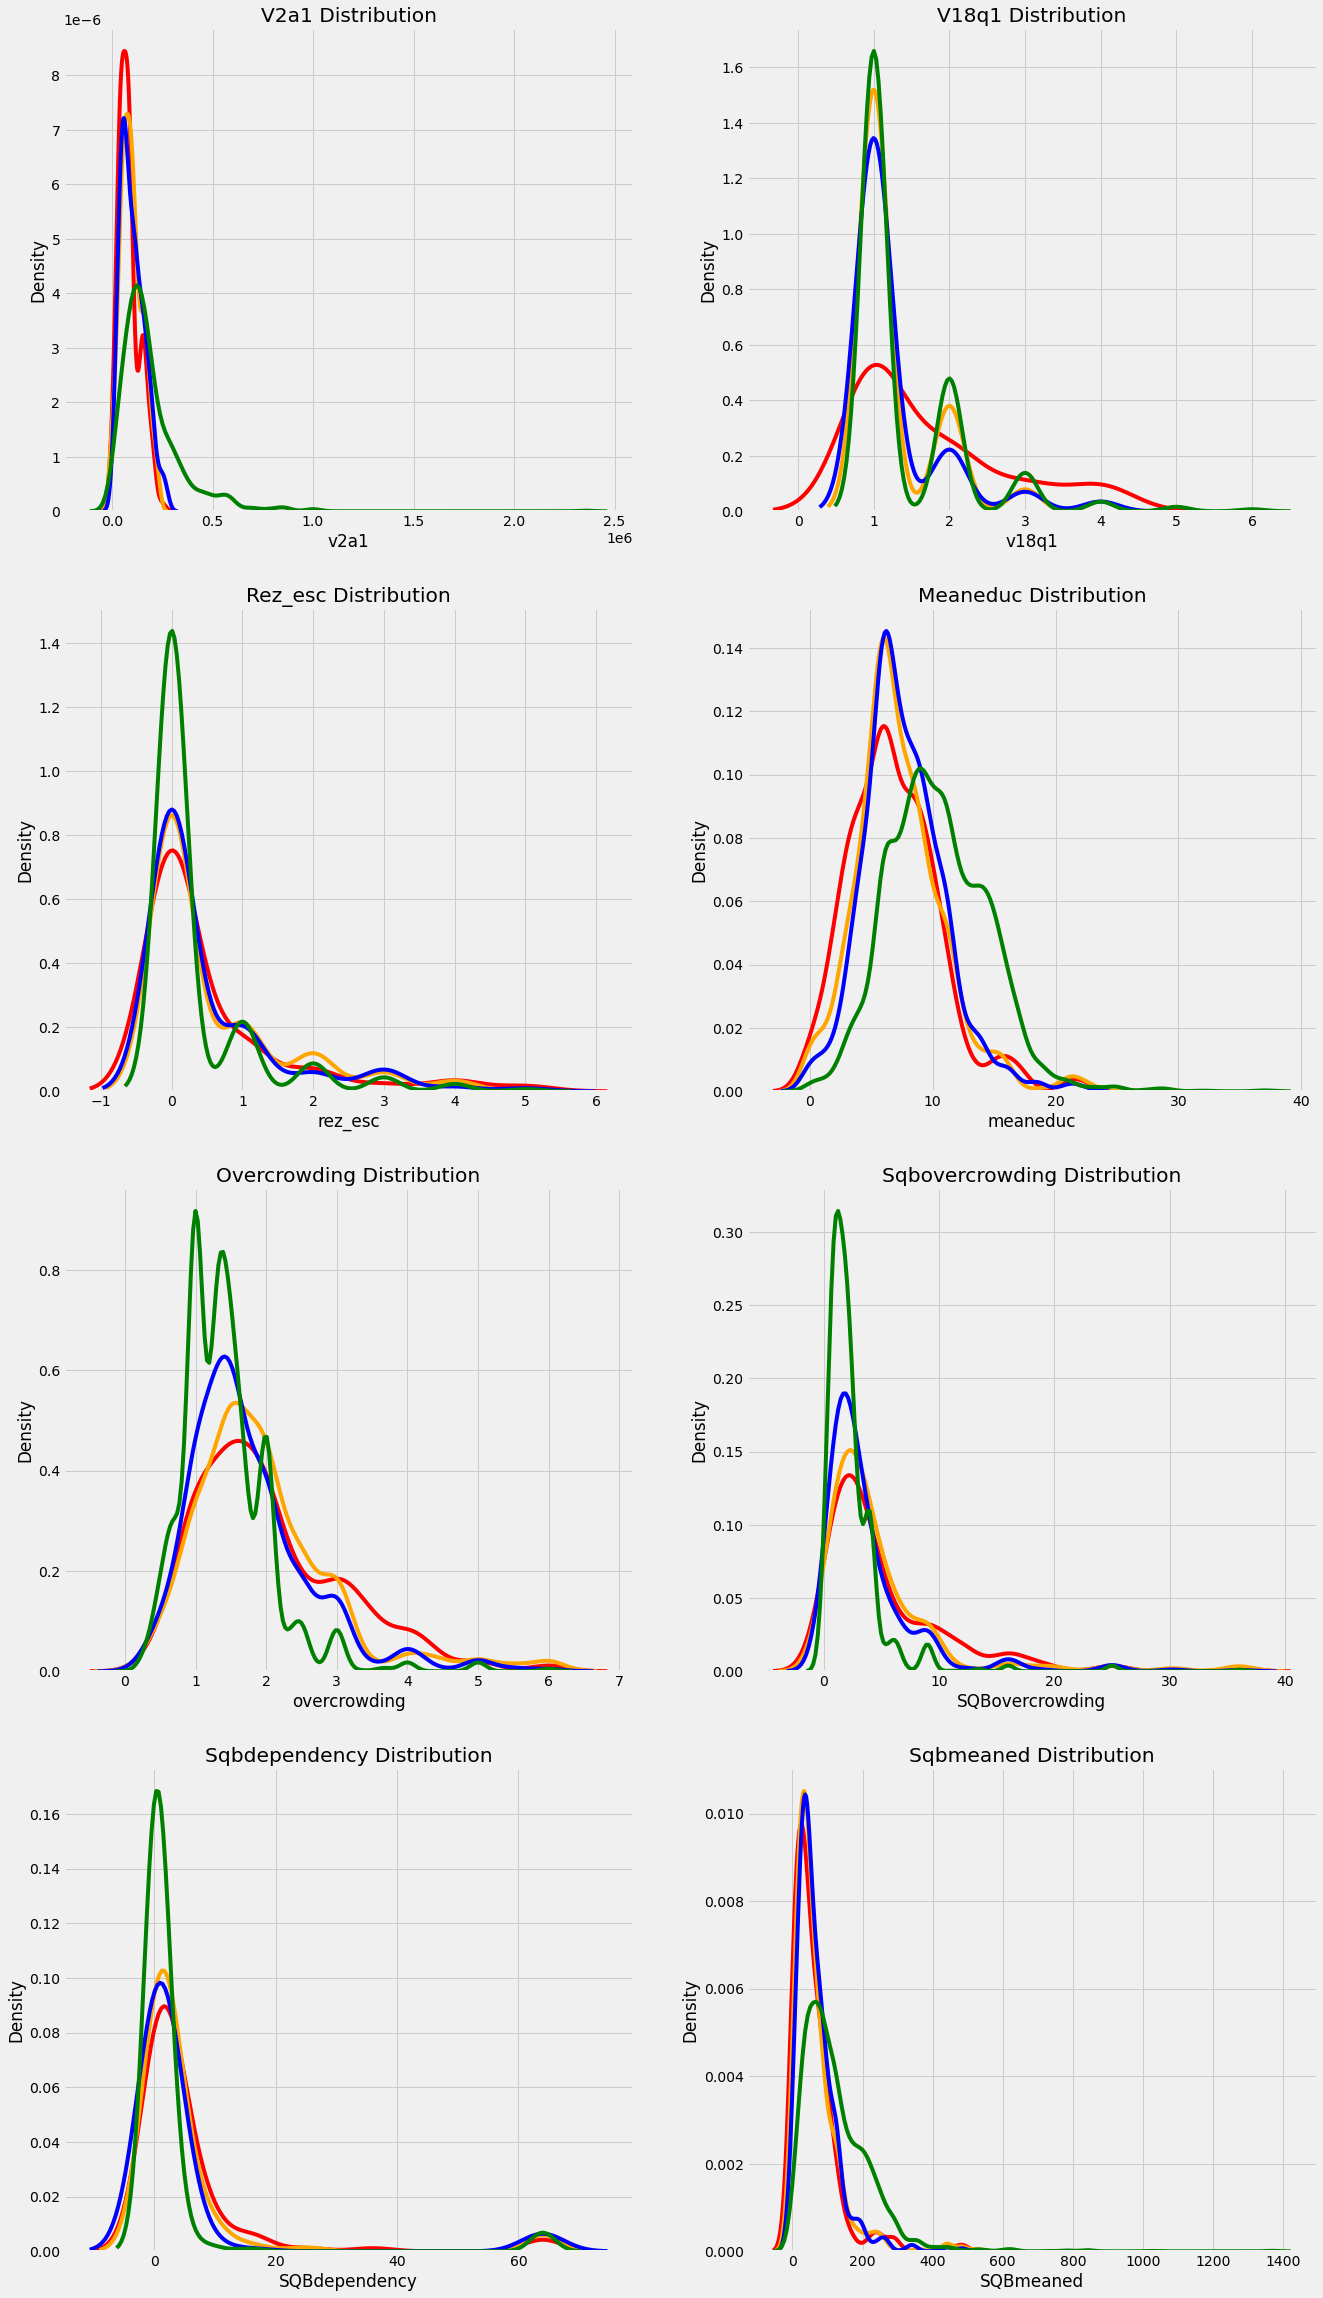

In [6]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight') # 스타일시트

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# x축
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # y축
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [7]:
train.select_dtypes('float')

,v2a1,v18q1,rez_esc,meaneduc,overcrowding,SQBovercrowding,SQBdependency,SQBmeaned
0,190000.0,NaN,NaN,10.00,1.000000,1.000000,0.0000,100.0000
1,135000.0,1.0,NaN,12.00,1.000000,1.000000,64.0000,144.0000
2,NaN,NaN,NaN,11.00,0.500000,0.250000,64.0000,121.0000
3,180000.0,1.0,1.0,11.00,1.333333,1.777778,1.0000,121.0000
4,180000.0,1.0,NaN,11.00,1.333333,1.777778,1.0000,121.0000
...,...,...,...,...,...,...,...,...
9552,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9553,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9554,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9555,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625


나중에 변수와 목표값 사이의 상관 관계를 계산하여 형상 간의 관계를 측정하겠지만, 이러한 그림을 통해 모형과 가장 "관련성 있는" 변수가 무엇인지 알 수 있습니다. 예를 들어, 가구 내 성인의 평균 교육을 나타내는 평균 교육은 빈곤 수준과 관련이 있는 것으로 보입니다: 높은 평균 성인 교육은 목표의 높은 가치로 이어지고 덜 심각한 빈곤 수준으로 이어집니다. 교육의 중요성에 대한 주제는 우리가 이 공책에서 계속해서 다시 보게 될 주제입니다!

### Object Columns


In [8]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


마지막 열 type은 아래와 같이 볼 수 있는 'object'입니다.

Id 및 idhogar 개체 유형은 식별 변수이므로 의미가 있습니다. 
그러나 나머지 열은 기계 학습을 수행하기 전에 해결해야 할 문자열과 숫자가 혼합된 것으로 보입니다. 

- dependency : 종속율, =(19세 미만 가구원 수)/(19~64세 가구원 수)

- edjefe : 남성 가장의 교육 연수는 에스콜라리(교육 연수), 세대주 및 성별 상호 작용을 기반으로 합니다(예=1 및 아니오=0).

- edjefa : 여성 가장의 교육 연수는 에스콜라리(교육 연수), 세대주 및 성별 상호 작용을 기반으로 합니다(예=1 및 아니오=0).

이러한 설명으로 문제가 해결되었습니다. 이 세 변수의 경우 "예" = 1 및 "아니오" = 0입니다. 매핑을 사용하여 변수를 수정하고 부동 변수로 변환할 수 있습니다.

In [9]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


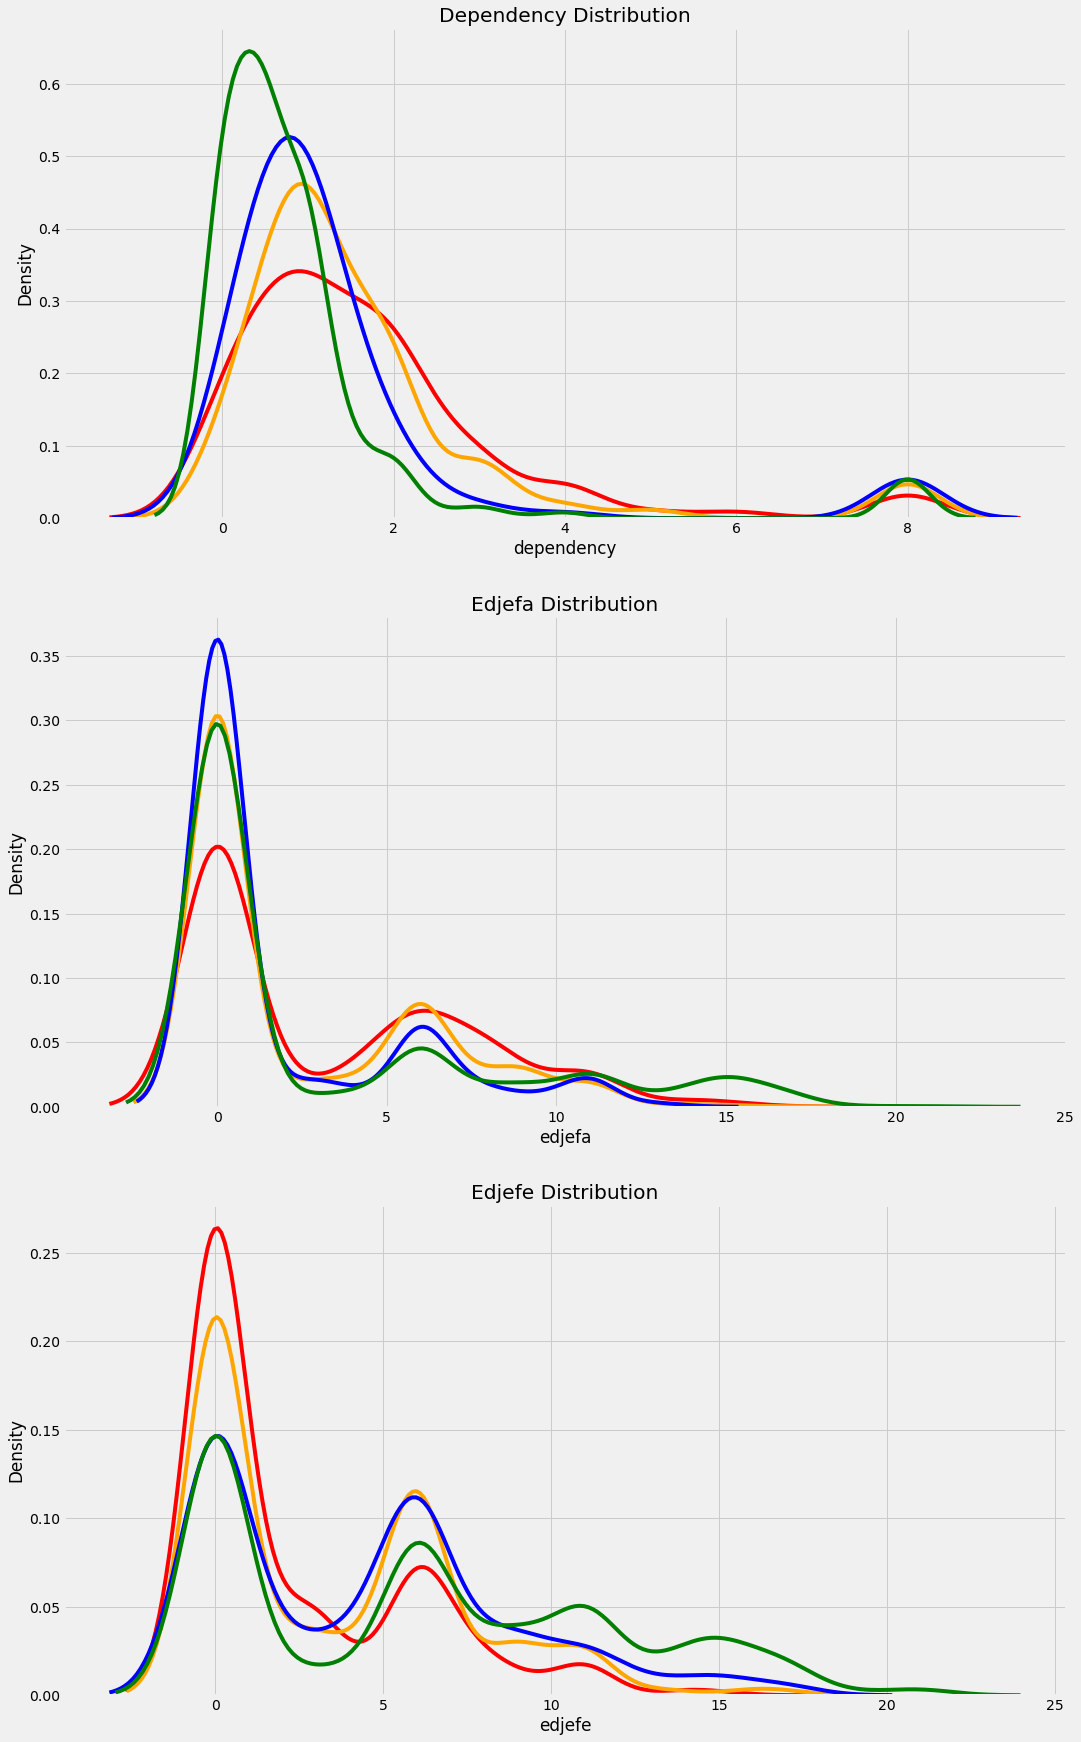

In [10]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [11]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Exploring Label Distribution

다음으로 레이블 분포를 보면 얼마나 불균형적인 문제인지 알 수 있습니다. 4가지 가능한 정수 수준이 있는데, 이것은 빈곤의 4가지 수준을 나타냅니다.
올바른 레이블을 보려면 parentesco1 == 1인 열에만 부분 집합을 취합니다. 이 열은 '가장'인 레이블이기 때문입니다. (식구 4명 빈곤 -> 가장 1명 빈곤)

아래 막대 그림은 (검정 레이블이 없으므로) 교육용 레이블의 분포를 보여줍니다.

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

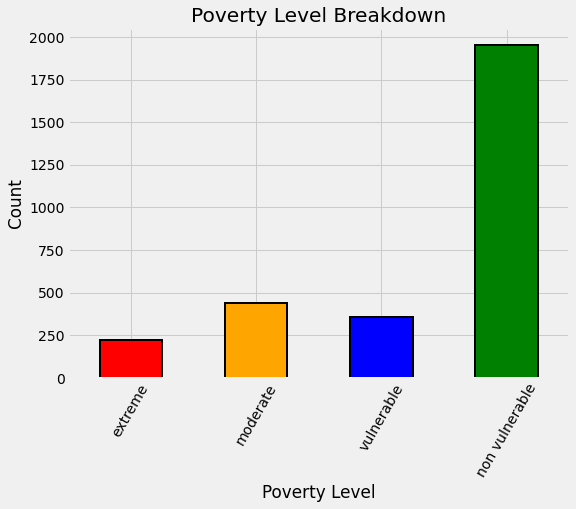

In [16]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']] # df.loc[row, columns]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

In [13]:
data['parentesco1'] == 1

0         True
1         True
2         True
3        False
4        False
         ...  
33408    False
33409     True
33410    False
33411    False
33412    False
Name: parentesco1, Length: 33413, dtype: bool

In [14]:
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]
train_labels

,Target,idhogar
0,4.0,21eb7fcc1
1,4.0,0e5d7a658
2,4.0,2c7317ea8
5,4.0,2b58d945f
8,4.0,d6dae86b7
...,...,...
9535,1.0,9bbf7c6ca
9541,2.0,e87e70c06
9545,4.0,a8eeafc29
9551,2.0,212db6f6c


In [15]:
label_counts = train_labels['Target'].value_counts().sort_index()
label_counts

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

우리는 불균형 클래스 문제를 다루고 있습니다(대회 주최자가 가중치 F1 대신 매크로 F1 점수를 메트릭으로 선택하는 이유는 매우 흥미롭습니다). 취약계층으로 분류하는 가구가 다른 어떤 범주보다 훨씬 많습니다. 극빈층이 가장 작습니다.

불균형 분류 문제의 한 가지 문제는 머신러닝 모델이 훨씬 적은 예를 보기 때문에 소수 수업을 예측하는 데 어려움을 겪을 수 있다는 것입니다. 이것을 인간의 관점에서 생각해보세요: 만약 우리가 빈곤을 분류하고 있고, 극심한 빈곤보다 빈곤이 없는 경우를 훨씬 더 많이 본다면, 우리는 더 적은 노출 때문에 높은 빈곤 가구를 식별하는 것을 더 어렵게 만들 것입니다. 클래스 불균형을 해결할 수 있는 한 가지 잠재적인 방법은 오버샘플링을 사용하는 것입니다(고급 노트북에서 다루어짐).

## Addressing Wrong Labels

다른 현실적인 데이터 세트와 마찬가지로 코스타리카 빈곤 데이터에도 몇 가지 문제가 있습니다. 일반적으로 데이터 과학 프로젝트의 80%는 데이터를 정리하고 이상 징후/오류를 수정하는 데 사용됩니다. 이는 사람 입력 오류, 측정 오류 또는 정확하지만 눈에 띄는 극단값일 수 있습니다. 이 문제에 대해, 같은 가정의 개인들은 다른 빈곤 수준을 가지고 있기 때문에 일부 라벨은 정확하지 않습니다. 왜 그럴지도 모르지만 가장을 진짜 꼬리표로 쓰라고 했습니다.

그 정보가 우리의 일을 훨씬 쉽게 만들어 주지만, 실제 문제에서 우리는 왜 라벨이 잘못되었는지, 그리고 그 문제를 스스로 해결할 수 있는 방법을 알아내야 할 것입니다. 이 섹션에서는 레이블의 문제를 수정할 필요는 없지만, 이 문제를 어떻게 처리할 수 있는지 보여주기 위해 노트에 보관했습니다.


### Identify Errors

먼저 오류를 찾아 수정해야 합니다. 가족 구성원의 레이블이 다른 가구를 찾기 위해 가구별로 데이터를 그룹화한 다음 대상의 고유 값이 하나만 있는지 확인할 수 있습니다.


In [17]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
all_equal

idhogar
001ff74ca    True
003123ec2    True
004616164    True
004983866    True
005905417    True
             ... 
ff9343a35    True
ff9d5ab17    True
ffae4a097    True
ffe90d46f    True
fff7d6be1    True
Name: Target, Length: 2988, dtype: bool

In [22]:
# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


한 가지 예를 살펴보겠습니다.


In [19]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최 측은 올바른 라벨이 가장의 라벨이며, 여기서 parentesco1 == 1이라고 말합니다. 이 가구의 경우, 올바른 라벨은 모든 구성원을 위한 3입니다. 우리는 이 가정의 모든 사람들을 올바른 빈곤 수준으로 재할당함으로써 (나중에 보여지는 것처럼) 이것을 바로잡을 수 있습니다. 실제 상황에서는 혼자서(또는 팀의 도움을 받아) 문제를 해결하는 어려운 결정을 내려야 할 수도 있습니다.


### Families without Heads of Household

우리는 같은 가구에 있는 개인에게 가장의 라벨을 지정함으로써 라벨 불일치를 수정할 수 있습니다. 하지만, 여러분은 이렇게 물을지도 모릅니다: "만약 가장이 없는 가정이 있다면요? 그리고 만약 그 가구 구성원들의 라벨에 대한 가치관이 다르면 어떻게 될까요?"

그럼, 당신이 물었으니, 그 질문을 정확히 조사해보죠!



In [25]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()
households_leader

idhogar
001ff74ca    1
003123ec2    1
004616164    1
004983866    1
005905417    1
            ..
ff9343a35    1
ff9d5ab17    1
ffae4a097    1
ffe90d46f    1
fff7d6be1    1
Name: parentesco1, Length: 2988, dtype: int64

In [28]:
households_leader[households_leader == 0].index

Index(['03c6bdf85', '09b195e7a', '1367ab31d', '1bc617b23', '374ca5a19',
       '61c10e099', '6b1b2405f', '896fe6d3e', 'a0812ef17', 'ad687ad89',
       'b1f4d89d7', 'bfd5067c2', 'c0c8a5013', 'd363d9183', 'f2bfa75c4'],
      dtype='object', name='idhogar')

In [26]:
# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :] 
households_no_head

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
4935,ID_717302050,NaN,0,8,0,1,1,0,NaN,0,2,2,0,2,2,0,4,4,4,4,6,NaN,4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,09b195e7a,2,2,0,4,1.000000,6.0,0.0,6.000000,0,0,1,0,0,0,0,0,0,5,0.800000,1,0,0,0,0,0,1,1,4,1,0,0,0,0,0,0,1,34,36,1156,16,36,4,0.640000,1.000000,36.000000,1156,3
4975,ID_ff6f13458,NaN,0,4,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,9,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,896fe6d3e,2,2,0,4,1.000000,9.0,0.0,7.500000,0,0,0,0,0,1,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,16,81,256,16,81,4,4.000000,1.000000,56.250000,256,3
5391,ID_64c9eabac,NaN,0,5,0,1,1,0,NaN,0,1,1,0,2,2,0,3,3,3,3,14,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,61c10e099,0,3,0,3,0.000000,6.0,0.0,8.666667,0,0,0,0,0,0,0,1,0,3,1.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,20,196,400,9,36,0,1.000000,0.000000,75.111115,400,3
5396,ID_8948b1f91,90000.0,0,5,0,1,1,0,NaN,2,1,3,1,1,2,3,2,5,5,5,3,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,374ca5a19,3,2,0,5,1.500000,6.0,0.0,8.500000,0,1,0,0,0,0,0,0,0,3,1.666667,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,0,1,10,9,100,25,36,9,2.777778,2.250000,72.250000,100,3
6443,ID_8ddb34d2c,NaN,0,3,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3.0,0.0,6.000000,1,0,0,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,7,0,49,16,9,4,4.000000,1.000000,36.000000,49,3
6444,ID_03e2f23b0,NaN,0,3,0,1,1,0,NaN,1,1,2,0,2,2,1,3,4,4,4,6,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3.0,0.0,6.000000,0,0,1,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,13,36,169,16,9,4,4.000000,1.000000,36.000000,169,3
7086,ID_ba2ac56bb,NaN,0,4,0,1,1,0,NaN,0,1,1,2,2,4,2,3,5,5,5,11,NaN,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1367ab31d,3,2,0,5,1.500000,16.0,0.0,18.000000,0,0,0,0,1,0,0,0,0,2,2.500000,1,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,1,19,121,361,25,256,9,6.250000,2.250000,324.000000,361,3
7438,ID_7ba374a80,NaN

In [27]:
print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [29]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


다행이네요! 이것은 머리도 없고 멤버들의 라벨 가치도 다른 가정을 걱정할 필요가 없다는 것을 의미해요! 주최자들에 따르면, 만약 한 가정에 가장이 없다면, 진정한 라벨은 없는 것이라고 합니다. 그러므로, 우리는 사실 가장이 없는 어떤 가정도 훈련에 사용하지 않을 것입니다. 그럼에도 불구하고, 이 데이터 조사 과정을 거치는 것은 여전히 좋은 연습입니다!


### Correct Errors

이제 우리는 가장이 있는 가구와 구성원의 빈곤 수준이 다른 가구들에 대한 라벨을 수정할 수 있습니다.



In [30]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


라벨에는 가장만 사용할 예정이기 때문에 이 단계가 꼭 필요한 것은 아니지만 실제 발생할 수 있는 데이터 오류를 수정하기 위한 워크플로를 보여줍니다. 야근이라고 생각하지 말고 경력을 위해 연습하세요!
